# **WiDS Datathon -- Model and Prediction**
### **Sugar_fast Team**

Submitted by Areerat Kichkha

### **Focus**
Creating classifiers to determine whether patients have a type of diabetes which could potentially inform later treatment in the ICU.

In [1]:
# Load libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [2]:
# Read TrainingWiDS2021 data and UnlabeledWiDS2021 data into pandas in two DataFrames

url_train = 'https://github.com/areeratk/Diabetes_Mellitus/blob/main/Resources/TrainingWiDS2021.csv?raw=true'
url_test = 'https://github.com/areeratk/Diabetes_Mellitus/blob/main/Resources/UnlabeledWiDS2021.csv?raw=true'
df = pd.read_csv(url_train)
test_df = pd.read_csv(url_test)

#Print the worksheet dataframe, df
print(df.shape)

#Print the predicting dataframe, test_df
print(test_df.shape)

(130157, 181)
(10234, 180)


### **Exploratory Data Analysis (EDA**)
*   Missing Data Analysis. Explore missing values in R, with mice. See https://github.com/areeratk/Diabetes_Mellitus/blob/main/diabetes_eda_Areerat.ipynb for discussion on recommended variables for dropping.
*   Exploring the data further in Pandas Profiling. See https://github.com/areeratk/Diabetes_Mellitus/blob/main/diabetes_eda_Areerat2.ipynb for discussion on dropping highly correlated variables among the predictors.

*   Further data exploration in the next cell below


In [3]:
#Further data exploration on the worksheet dataframe, df

# Encode string variables as new columns
df.loc[:, 'ethnicity_encode'] = pd.factorize(df['ethnicity'])[0].reshape(-1,1)
df.loc[:, 'gender_encode'] = pd.factorize(df['gender'])[0].reshape(-1,1)
df.loc[:, 'hospital_admit_source_encode'] = pd.factorize(df['hospital_admit_source'])[0].reshape(-1,1)
df.loc[:, 'icu_admit_source_encode'] = pd.factorize(df['icu_admit_source'])[0].reshape(-1,1)
df.loc[:, 'icu_stay_type_encode'] = pd.factorize(df['icu_stay_type'])[0].reshape(-1,1)
df.loc[:, 'icu_type_encode'] = pd.factorize(df['icu_type'])[0].reshape(-1,1)

# Create new variables to solve missing data and high correlation among predictors issues
df['d1_diasbp_invasive_diff'] = df['d1_diasbp_invasive_max'] - df['d1_diasbp_invasive_min']
df['d1_diasbp_diff'] = df['d1_diasbp_max'] - df['d1_diasbp_min']
df['d1_heartrate_diff'] = df['d1_heartrate_max'] - df['d1_heartrate_min']
df['d1_mbp_diff'] = df['d1_mbp_max'] - df['d1_mbp_min']
df['d1_spo2_diff'] = df['d1_spo2_max'] - df['d1_spo2_min']
df['d1_sysbp_diff'] = df['d1_sysbp_max'] - df['d1_sysbp_min']
df['d1_calcium_diff'] = df['d1_calcium_max'] - df['d1_calcium_min']
df['d1_inr_diff'] = df['d1_inr_max'] - df['d1_inr_min']
df['d1_temp_diff'] = df['d1_temp_max'] - df['d1_temp_min']
df['h1_diasbp_diff'] = df['h1_diasbp_max'] - df['h1_diasbp_min']
df['h1_heartrate_diff'] = df['h1_heartrate_max'] - df['h1_heartrate_min']
df['h1_mbp_diff'] = df['h1_mbp_max'] - df['h1_mbp_min']
df['h1_resprate_diff'] = df['h1_resprate_max'] - df['h1_resprate_min']
df['h1_spo2_diff'] = df['h1_spo2_max'] - df['h1_spo2_min']
df['h1_sysbp_diff'] = df['h1_sysbp_max'] - df['h1_sysbp_min']
df['gcs_sum']=df['gcs_eyes_apache']+df['gcs_motor_apache']+df['gcs_verbal_apache']
df['bmi_calculated'] = 10000 * df['weight']/(df['height']**2)

# Drop columns of the original variables after columns of further relevant and related variables are created
df = df.drop(['d1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_spo2_max', 'd1_spo2_min',
              'd1_sysbp_max', 'd1_sysbp_min', 'd1_calcium_max', 'd1_calcium_min', 'd1_inr_max', 'd1_inr_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min',
              'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_max', 'h1_sysbp_min', 
              'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache', 'ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'bmi'
              ], axis=1)

# Impute remaining missing value with zeroes
df = df.fillna(0)

#Read cleaned df dataframe ready for machine learning models
df

,Unnamed: 0,encounter_id,hospital_id,age,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_unable_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_noninvasive_max,...,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus,ethnicity_encode,gender_encode,hospital_admit_source_encode,icu_admit_source_encode,icu_stay_type_encode,icu_type_encode,d1_diasbp_invasive_diff,d1_diasbp_diff,d1_heartrate_diff,d1_mbp_diff,d1_spo2_diff,d1_sysbp_diff,d1_calcium_diff,d1_inr_diff,d1_temp_diff,h1_diasbp_diff,h1_heartrate_diff,h1_mbp_diff,h1_resprate_diff,h1_spo2_diff,h1_sysbp_diff,gcs_sum,bmi_calculated
0,1,214826,118,68.0,0,180.3,92,0.541667,0,73.9,2.3,113.0,502.01,0,0,0.4,31.0,2.51,0.0,0.0,168.0,118.0,27.4,0,40.0,0.0,0.0,0.0,0.000,36.0,134.0,39.3,0.0000,0,14.1,68.0,37.0,66.0,40.0,89.0,...,0.000000,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,14.0,31.0,47.0,43.0,26.0,58.0,1.1,0.00,2.7,5.0,11.0,1.0,8.0,26.0,16.0,13.0,22.732803
1,2,246060,81,77.0,0,160.0,90,0.927778,0,70.2,0.0,108.0,203.01,0,0,0.0,9.0,0.56,1.0,0.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.450,33.0,145.0,35.1,0.0000,1,12.7,95.0,31.0,0.0,0.0,120.0,...,51.000000,37.0,37.0,7.450,7.450,51.0,51.0,51.0,51.0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0.0,64.0,46.0,82.0,30.0,92.0,0.6,0.00,1.2,13.0,14.0,28.0,3.0,25.0,24.0,5.0,27.421875
2,3,276985,118,25.0,0,172.7,93,0.000694,0,95.3,0.0,122.0,703.03,0,0,0.0,0.0,0.00,0.0,0.0,0.0,102.0,0.0,0,68.0,0.0,0.0,0.0,0.000,37.0,0.0,36.7,0.0000,0,0.0,88.0,48.0,0.0,0.0,102.0,...,0.000000,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0.0,40.0,28.0,34.0,7.0,43.0,0.0,0.00,0.3,30.0,18.0,8.0,4.0,7.0,24.0,14.0,31.952749
3,4,262220,118,81.0,1,165.1,92,0.000694,0,61.7,0.0,203.0,1206.03,1,0,0.0,0.0,0.00,0.6,0.0,185.0,114.0,25.9,1,60.0,30.0,30.0,142.0,7.390,4.0,0.0,34.8,0.0000,1,8.0,48.0,42.0,92.0,52.0,84.0,...,236.666667,36.0,33.0,7.370,7.340,337.0,265.0,337.0,337.0,0,0,0,0,0,0,0,0,0,1,2,2,0,0,32.0,6.0,24.0,0.0,5.0,74.0,0.0,0.50,3.2,18.0,4.0,21.0,1.0,1.0,30.0,15.0,22.635548
4,5,201746,33,19.0,0,188.0,91,0.073611,0,0.0,0.0,119.0,601.01,0,0,0.0,0.0,0.00,0.0,0.0,0.0,60.0,0.0,0,103.0,0.0,0.0,0.0,0.000,16.0,0.0,36.7,0.0000,0,0.0,99.0,57.0,0.0,0.0,104.0,...,0.000000,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,-1,1,0,1,0.0,42.0,29.0,14.0,4.0,27.0,0.0,0.00,0.5,31.0,13.0,12.0,0.0,0.0,10.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130152,130153,164758,7,50.0,0,175.3,1109,0.023611,0,90.0,0.0,110.0,104.01,0,0,0.0,0.0,0.00,0.0,0.0,0.0,106.0,0.0,0,120.0,0.0,0.0,0.0,0.000,50.0,0.0,36.2,1751.1552,0,0.0,102.0,82.0,0.0,0.0,120.0,...,0.000000,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,1,0,6,0.0,20.0,12.0,16.0,9.0,27.0,0.0,0.00,0.4,20.0,12.0,16.0,18.0,9.0,27.0,15.0,29.287256
130153,130154,197653,7,79.0,0,162.6,1106,0.009722,0,78.4,3.5,105.0,207.01,0,0,0.7,32.0,1.07,0.0,0.0,139.0,112.0,39.0,0,125.0,0.0,0.0,0.0,0.000,42.0,140.0,36.4,5724.7776,0,9.5,97.0,63.0,0.0,0.0,125.0,...,0.000000,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,3,1,0,4,0.0,34.0,23.0,

In [4]:
#Prepare the predicting dataframe, testing_df, following the same procedure describe in the immidiate cell above

# Encode string variables as new columns
test_df.loc[:, 'ethnicity_encode'] = pd.factorize(test_df['ethnicity'])[0].reshape(-1,1)
test_df.loc[:, 'gender_encode'] = pd.factorize(test_df['gender'])[0].reshape(-1,1)
test_df.loc[:, 'hospital_admit_source_encode'] = pd.factorize(test_df['hospital_admit_source'])[0].reshape(-1,1)
test_df.loc[:, 'icu_admit_source_encode'] = pd.factorize(test_df['icu_admit_source'])[0].reshape(-1,1)
test_df.loc[:, 'icu_stay_type_encode'] = pd.factorize(test_df['icu_stay_type'])[0].reshape(-1,1)
test_df.loc[:, 'icu_type_encode'] = pd.factorize(test_df['icu_type'])[0].reshape(-1,1)

# Create new variables to solve missing data and high correlation among predictors issues
test_df['d1_diasbp_invasive_diff'] = test_df['d1_diasbp_invasive_max'] - test_df['d1_diasbp_invasive_min']
test_df['d1_diasbp_diff'] = test_df['d1_diasbp_max'] - test_df['d1_diasbp_min']
test_df['d1_heartrate_diff'] = test_df['d1_heartrate_max'] - test_df['d1_heartrate_min']
test_df['d1_mbp_diff'] = test_df['d1_mbp_max'] - test_df['d1_mbp_min']
test_df['d1_spo2_diff'] = test_df['d1_spo2_max'] - test_df['d1_spo2_min']
test_df['d1_sysbp_diff'] = test_df['d1_sysbp_max'] - test_df['d1_sysbp_min']
test_df['d1_calcium_diff'] = test_df['d1_calcium_max'] - test_df['d1_calcium_min']
test_df['d1_inr_diff'] = test_df['d1_inr_max'] - test_df['d1_inr_min']
test_df['d1_temp_diff'] = test_df['d1_temp_max'] - test_df['d1_temp_min']
test_df['h1_diasbp_diff'] = test_df['h1_diasbp_max'] - test_df['h1_diasbp_min']
test_df['h1_heartrate_diff'] = test_df['h1_heartrate_max'] - test_df['h1_heartrate_min']
test_df['h1_mbp_diff'] = test_df['h1_mbp_max'] - test_df['h1_mbp_min']
test_df['h1_resprate_diff'] = test_df['h1_resprate_max'] - test_df['h1_resprate_min']
test_df['h1_spo2_diff'] = test_df['h1_spo2_max'] - test_df['h1_spo2_min']
test_df['h1_sysbp_diff'] = test_df['h1_sysbp_max'] - test_df['h1_sysbp_min']
test_df['gcs_sum']=test_df['gcs_eyes_apache']+test_df['gcs_motor_apache']+test_df['gcs_verbal_apache']
test_df['bmi_calculated'] = 10000 * test_df['weight']/(test_df['height']**2)

# Drop columns of the original variables after columns of further relevant and related variables are created
test_df = test_df.drop(['d1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_spo2_max', 'd1_spo2_min',
              'd1_sysbp_max', 'd1_sysbp_min', 'd1_calcium_max', 'd1_calcium_min', 'd1_inr_max', 'd1_inr_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min',
              'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_max', 'h1_sysbp_min', 
              'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache', 'ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'bmi'
              ], axis=1)

# Impute remaining missing value with zeroes
test_df = test_df.fillna(0)

#Read cleaned test_df dataframe ready for prediction from a selected machine learning model
test_df

,Unnamed: 0,encounter_id,hospital_id,age,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_unable_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_noninvasive_max,...,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,ethnicity_encode,gender_encode,hospital_admit_source_encode,icu_admit_source_encode,icu_stay_type_encode,icu_type_encode,d1_diasbp_invasive_diff,d1_diasbp_diff,d1_heartrate_diff,d1_mbp_diff,d1_spo2_diff,d1_sysbp_diff,d1_calcium_diff,d1_inr_diff,d1_temp_diff,h1_diasbp_diff,h1_heartrate_diff,h1_mbp_diff,h1_resprate_diff,h1_spo2_diff,h1_sysbp_diff,gcs_sum,bmi_calculated
0,1,144740,10141,72,0,152.4,82,0.015278,0,0.0,2.8,110.0,104.01,0,0,1.9,44.0,1.49,0.0,0.0,97.0,38.0,39.9,0,54.0,0.0,0.0,0.0,0.0,31.0,130.0,36.4,0.0,0,5.4,104.0,40.0,0.0,0.0,123.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,64.0,28.0,69.0,4.0,73.0,0.5,0.0,3.1,0.0,2.0,0.0,0.0,1.0,0.0,15.0,0.000000
1,2,141990,10141,86,0,175.3,82,0.000000,0,0.0,0.0,117.0,106.01,0,0,0.0,19.0,0.92,0.0,0.0,73.0,116.0,0.0,0,41.0,0.0,0.0,0.0,0.0,53.0,142.0,36.3,0.0,0,0.0,101.0,27.0,0.0,0.0,129.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,74.0,60.0,88.0,5.0,116.0,0.0,0.0,0.4,20.0,12.0,35.0,7.0,2.0,62.0,15.0,0.000000
2,3,142038,10141,72,0,162.6,82,0.003472,0,0.0,3.2,302.0,109.01,0,0,0.9,24.0,0.77,0.0,0.0,84.0,104.0,34.8,0,117.0,0.0,0.0,0.0,0.0,38.0,137.0,36.4,0.0,0,4.6,97.0,61.0,0.0,0.0,117.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,36.0,30.0,40.0,14.0,43.0,0.6,0.5,1.0,0.0,6.0,0.0,0.0,3.0,0.0,15.0,0.000000
3,4,138628,10141,66,0,177.8,82,0.884028,0,0.0,0.0,113.0,501.05,0,0,0.0,0.0,0.00,0.0,0.0,0.0,110.0,0.0,0,61.0,0.0,0.0,0.0,0.0,56.0,0.0,36.6,0.0,1,0.0,77.0,51.0,0.0,0.0,110.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.0,26.0,24.0,49.0,19.0,50.0,0.0,0.0,1.2,0.0,12.0,0.0,28.0,5.0,0.0,14.0,0.000000
4,5,141682,10141,89,0,170.2,82,0.013194,0,0.0,3.4,117.0,106.01,0,0,0.4,26.0,1.50,0.0,0.0,99.0,34.0,33.0,0,136.0,0.0,0.0,0.0,0.0,35.0,133.0,36.5,0.0,0,5.2,88.0,49.0,0.0,0.0,136.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,2,0,0,0,0.0,39.0,24.0,65.0,7.0,80.0,0.2,0.0,0.9,4.0,4.0,13.0,6.0,3.0,3.0,15.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10229,10230,143750,10140,36,0,170.1,1108,1.696528,0,108.6,0.0,305.0,901.02,0,0,0.0,0.0,0.00,0.0,0.0,0.0,111.0,29.0,0,127.0,0.0,0.0,0.0,0.0,45.0,0.0,36.5,2284.0,0,7.2,98.0,68.0,0.0,0.0,127.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,30.0,43.0,35.0,3.0,48.0,0.0,0.0,0.3,4.0,17.0,3.0,0.0,0.0,4.0,14.0,37.533684
10230,10231,143813,10140,61,0,160.0,1108,0.033333,0,82.3,0.0,124.0,305.02,0,0,0.0,33.0,1.15,0.0,0.0,94.0,106.0,27.0,0,166.0,0.0,0.0,0.0,0.0,49.0,139.0,36.7,6911.0,0,11.2,116.0,56.0,0.0,0.0,166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,60.0,37.0,85.0,5.0,102.6,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,15.0,32.148438
10231,10232,137126,10140,74,0,165.1,1108,0.757639,0,62.0,0.0,

### **Feature Selection Process**
After the above exploratory data analysis above, the feature selection process continues as follows.


*   Feature fine-tunning in the RandomForest model based on feauture importance reports.
*   Confirming selections of some features based on public information about how these features have been selected or dropped, including domain reasoning. Referenced notebooks are such as https://www.kaggle.com/usharengaraju/widsdatathon2021-catboost-starter and https://www.kaggle.com/yubiabia98/visualization-exploratory-data-analysis-light, etc.



In [5]:
#split dataset in features and target variable in the worksheet dataframe, df
feature_cols = [
 'age',
 'bmi_calculated',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'gcs_sum',
 'heart_rate_apache',
 'map_apache',
 'resprate_apache',
 'temp_apache',
 'd1_diasbp_diff',
 'd1_heartrate_diff',
 'd1_mbp_diff',
 'd1_resprate_max',
 'd1_spo2_diff',
 'd1_sysbp_diff',
 'd1_temp_diff',
 'd1_bun_max',
 'd1_calcium_diff',
 'd1_glucose_max',
 'd1_hco3_max',
 'd1_platelets_max',
 'd1_potassium_min',
 'd1_sodium_min',
 'h1_glucose_max',
 ]
X = df[feature_cols] # Features
y = df.diabetes_mellitus # Target variable

In [6]:
#Keep only relevant features in the predicting dataframe, testing_df, similar to the features in the worksheet dataframe immediately above
test_feature_cols = [
 'age',
 'bmi_calculated',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'gcs_sum',
 'heart_rate_apache',
 'map_apache',
 'resprate_apache',
 'temp_apache',
 'd1_diasbp_diff',
 'd1_heartrate_diff',
 'd1_mbp_diff',
 'd1_resprate_max',
 'd1_spo2_diff',
 'd1_sysbp_diff',
 'd1_temp_diff',
 'd1_bun_max',
 'd1_calcium_diff',
 'd1_glucose_max',
 'd1_hco3_max',
 'd1_platelets_max',
 'd1_potassium_min',
 'd1_sodium_min',
 'h1_glucose_max',
 ]
Xt = test_df[feature_cols] # Features for the test-df dataframe


### **Create Classifiers using Machine Learning Models**


*   Condider two models to create classifiers: RandomForest and Decision Tree.  
*   Work on the RandomForest model to continue fine-tuning features by observing its feature importance reports
*   Print accuracy score and classification report for each model to compare after features are well selected
*   Calculate and plot AUC-ROC curves for each model both on the test data in the worksheet dataframe, df, and on the predicting data frame.

In [7]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [8]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.8205285802089736

In [9]:
# Calculate classification report
from sklearn.metrics import classification_report
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89     30616
           1       0.65      0.37      0.47      8432

    accuracy                           0.82     39048
   macro avg       0.75      0.66      0.68     39048
weighted avg       0.80      0.82      0.80     39048



In [10]:
#Sort the features by their importance
sorted(zip(rf.feature_importances_, feature_cols), reverse=True)

[(0.17300937417803156, 'd1_glucose_max'),
 (0.06411480877870541, 'bmi_calculated'),
 (0.058027843157943605, 'h1_glucose_max'),
 (0.04459985893498656, 'd1_bun_max'),
 (0.043070455356747354, 'age'),
 (0.04051867205320513, 'heart_rate_apache'),
 (0.03763651997686868, 'apache_3j_diagnosis'),
 (0.03754545179162651, 'map_apache'),
 (0.03753996570850406, 'd1_platelets_max'),
 (0.03744176327121081, 'd1_heartrate_diff'),
 (0.03717210769900556, 'd1_sysbp_diff'),
 (0.03554220123279837, 'd1_diasbp_diff'),
 (0.03465967866404248, 'd1_mbp_diff'),
 (0.03407300262375103, 'resprate_apache'),
 (0.03274751744897238, 'd1_resprate_max'),
 (0.032587534307971476, 'temp_apache'),
 (0.032289080450084606, 'd1_temp_diff'),
 (0.031552791313225435, 'apache_2_diagnosis'),
 (0.03128584893775316, 'd1_potassium_min'),
 (0.030413124395133235, 'd1_spo2_diff'),
 (0.028714175991381218, 'd1_sodium_min'),
 (0.027858768710272742, 'd1_hco3_max'),
 (0.020421156835792743, 'gcs_sum'),
 (0.017178298181985886, 'd1_calcium_diff')]

In [12]:
# Probabilities for each class
rf_probs = rf.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_auc_score
roc_auc_score(y_pred, rf_probs)

1.0

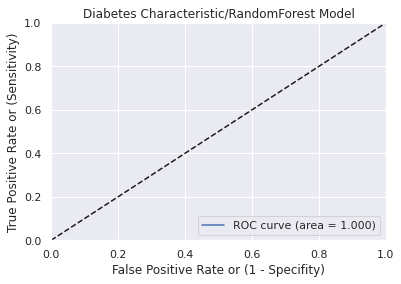

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_pred, rf_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Diabetes Characteristic/RandomForest Model')
plt.legend(loc="lower right")
plt.savefig('rf_y_pred.png')

In [14]:
#Use the RandomForest classifiers above to determine whether patients have a type of diabetes
TARGET_COL = "diabetes_mellitus"
test_df[TARGET_COL] = rf.predict(Xt)

#Read the predicting results
test_df[["encounter_id","diabetes_mellitus"]]

,encounter_id,diabetes_mellitus
0,144740,0
1,141990,0
2,142038,0
3,138628,0
4,141682,0
...,...,...
10229,143750,0
10230,143813,0
10231,137126,0
10232,135652,0


In [15]:
#Save the RandomForest predicting results in a csv submission file
test_df[["encounter_id","diabetes_mellitus"]].to_csv("submission_AK_Sugar_fast.csv",index=False)

In [16]:
# Probabilities for each predicting class
rf_probs1 = rf.predict_proba(Xt)[:, 1]

from sklearn.metrics import roc_auc_score
roc_auc_score(test_df[TARGET_COL], rf_probs1)

1.0

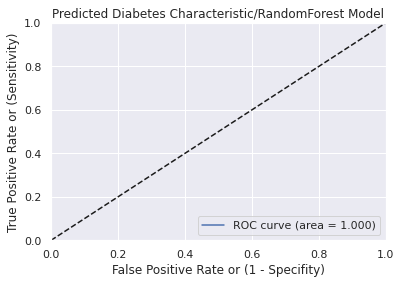

In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(test_df[TARGET_COL], rf_probs1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Predicted Diabetes Characteristic/RandomForest Model')
plt.legend(loc="lower right")
plt.savefig('rf_y_target.png')

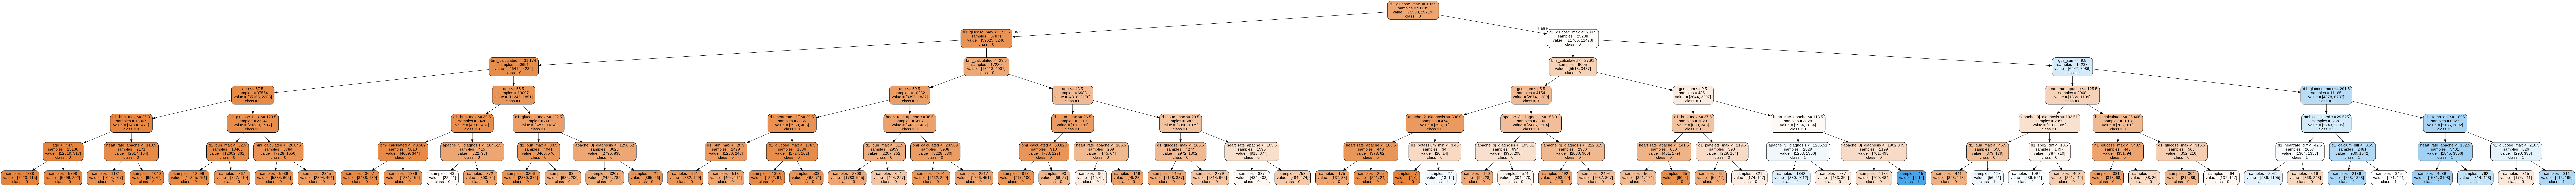

In [19]:
#Decision tree appoach to further observe explanatory ability of selected features 
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

decision_tree = tree.DecisionTreeClassifier(max_depth = 6)
decision_tree.fit(X_train,y_train)

# Predict results for test dataset
y_pred_dt = decision_tree.predict(X_test)

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 6,
                              impurity = False,
                              feature_names = feature_cols,
                              class_names = ['0', '1'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
img.save('decision_tree_AK_Sugar_fast.png')
PImage("decision_tree_AK_Sugar_fast.png", height=2000, width=1900)

In [20]:
# The Decision Tree Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_dt))

Accuracy: 0.812359147715632


In [21]:
# Calculate classification report from the Decision Tree Approach
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.85      0.92      0.89     30616
           1       0.60      0.41      0.48      8432

    accuracy                           0.81     39048
   macro avg       0.72      0.67      0.68     39048
weighted avg       0.79      0.81      0.80     39048



In [22]:
# Probabilities for each class
dt_probs = decision_tree.predict_proba(X_test)[:, 1]

roc_auc_score(y_pred_dt, dt_probs)

1.0

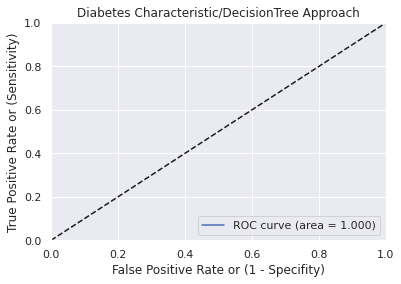

In [23]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_pred_dt, dt_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Diabetes Characteristic/DecisionTree Approach')
plt.legend(loc="lower right")
plt.savefig('dt_y_pred_dt.png')

In [24]:
#Use the decision tree classifiers above to determine whether patients have a type of diabetes
TARGET_COL = "diabetes_mellitus"
test_df[TARGET_COL] = decision_tree.predict(Xt)

#Read the predicting results
test_df[["encounter_id","diabetes_mellitus"]]

,encounter_id,diabetes_mellitus
0,144740,0
1,141990,0
2,142038,0
3,138628,0
4,141682,0
...,...,...
10229,143750,0
10230,143813,0
10231,137126,0
10232,135652,0


In [25]:
#Save the predicting results in a csv submission file
test_df[["encounter_id","diabetes_mellitus"]].to_csv("submission_AK_Sugar_fast2.csv",index=False)

In [26]:
# Probabilities for each class
dt_probs1 = decision_tree.predict_proba(Xt)[:, 1]

roc_auc_score(test_df[TARGET_COL], dt_probs1)

1.0

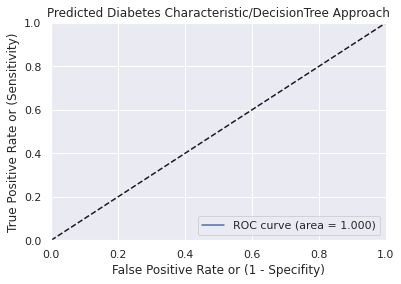

In [27]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(test_df[TARGET_COL], dt_probs1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Predicted Diabetes Characteristic/DecisionTree Approach')
plt.legend(loc="lower right")
plt.savefig('dt_y_target.png')

### **Conclusion Remarks**


*   The RandomForest model serves feature fine-tunning purposes.  By nature, it also is helpful in alleviating overfitting issues.
*   The RandomForest model has slightly higher accuracy (about 1%) as compared to the Decision Tree approach.
*   Looking at the classification reports, we see that RandomForest has higher precision and thus higher proportion of predictions that class 1 are true. DecisionTree, however, provides higher recall and thus higher proportion of the true positives of class 1 that are identified as such. DecisionTree also has higher f-1 score for class 1 which is a useful reference when the two classes are imbalance.   
*   The Decision Tree approach also has slightly higher auc-roc score when performing on the predicting dataframe. 
*   The Decision Tree approach is selected to create classifiers to determine whether patients have diabetes because it performs better in identifying true positives of class 1 since providing diabetes treatment to false positives would lead to more mulfunctions.  
*   The Decision Tree approach helps us further see where elses we may look when common determinants mystify us in trade-offs of possible overfitting and bias. These possibilities are likely low given close measures of their performances after our heavy feature fine-tunning.